<a href="https://www.kaggle.com/code/subhadipde2000/text-summarization-gemma-3-fine-tuning-with-lora?scriptVersionId=240150006" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing/Updating Necessary Libraries:

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 32.8 MB/s eta 0:00:00


# Importing Necessary Libraries:

In [2]:
import os
import keras
import random
import warnings
import keras_nlp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

2025-05-16 20:50:18.498695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747428618.678682      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747428618.730384      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

# Setting Up Keras Backend:

In [4]:
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"
os.environ["JAX_PLATFORMS"] = ""

# Reading the Datasets:

In [5]:
train_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv'
valid_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv'
test_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv'

In [6]:
def read_dataset():
    """
    Read all three datasets as a single dataset and shuffle it.
    """
    
    df1 = pd.read_csv(train_dir)
    df2 = pd.read_csv(valid_dir)
    df3 = pd.read_csv(test_dir)
    df = pd.concat([df1, df2, df3])

    df.drop(['id'], axis=1, inplace=True)
    df.rename(columns = {"article":"news", "highlights":"summary"}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [7]:
df = read_dataset()
df.head()

,news,summary
0,(CNN) -- Brandon Holt didn't make it to his 7t...,"Brandon Holt, 6, was shot in the head by a 4-y..."
1,Tests on the long-lost skeleton of Richard III...,"Tests on skeleton of Richard III, a king of En..."
2,"LONDON, England (CNN) -- Sky News, the British...",Sky News said airing the appeal would compromi...
3,What started with a cheap shot four years ago ...,Jon Jones defends his UFC light heavyweight ti...
4,"By . Rob Preece . PUBLISHED: . 04:01 EST, 19 J...","Software boss Hans Reiser murdered wife Nina, ..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311971 entries, 0 to 311970
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   news     311971 non-null  object
 1   summary  311971 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB


# Exploratory Data Analysis:

In [9]:
def plot():
    
    df["news length"] = df["news"].apply(lambda x: len(x.split()))
    df["summary length"] = df["summary"].apply(lambda x: len(x.split()))
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=250)
    sns.histplot(data=df, x="news length", bins=100, ax=axes[0], kde=True).set_title("Distribution of news lengths (number of words)")
    sns.histplot(data=df, x="summary length", bins=100, ax=axes[1], kde=True).set_title("Distribution of summary lengths (number of words)")
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
    return

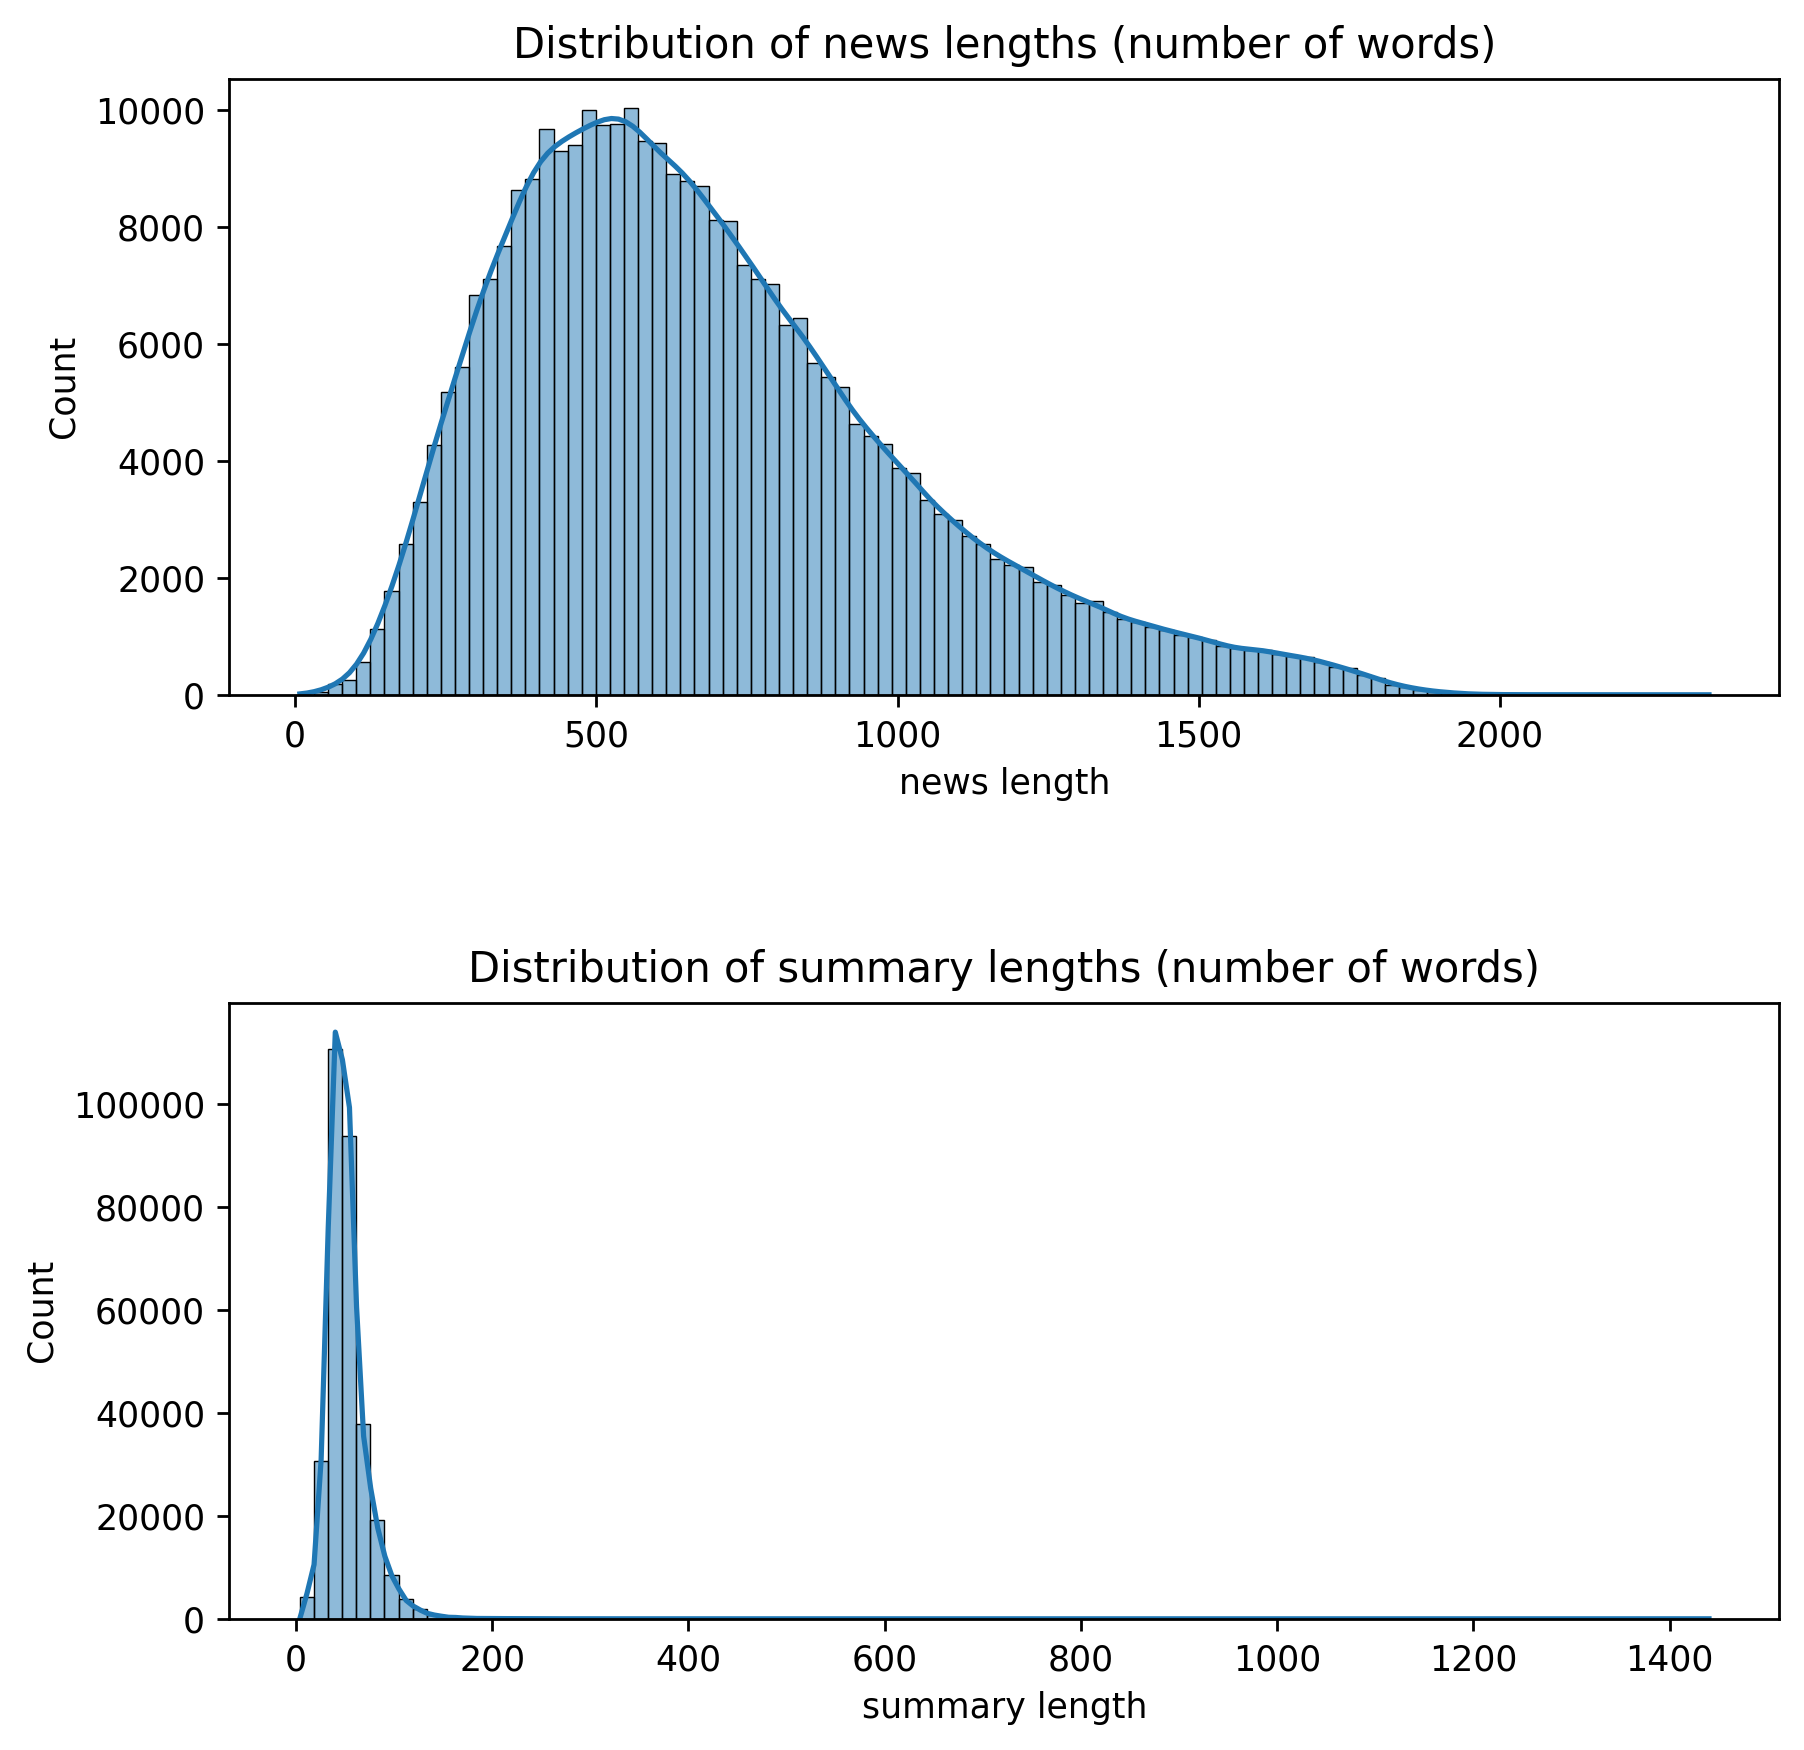

In [10]:
plot()

# Function for Coloring and Formatting Text:

In [11]:
def colorize_text(text):
    for word, color in zip(["System: ", "Instructions: ", "News: ", "Summary: "], ["green", "yellow", "red", "cyan"]):
        text = text.replace(f"{word}", f"<font color='{color}' size='4'><strong>{word}</strong></font>")
    return text

In [12]:
# Visualizing a random example:

row = df.loc[random.randint(0, len(df))]
text = f"News: \n\n{row.news} \n\nSummary: \n\n{row.summary}"
display(Markdown(colorize_text(text)))

<font color='red' size='4'><strong>News: </strong></font>

Pregnant women at risk of mental health problems will receive extra support after the tragic deaths of a new mother Charlotte Bevan (pictured) and her four-day-old daughter . Pregnant women at risk of mental health problems will receive extra support after the tragic deaths of a new mother and her four-day-old daughter. The National Institute for Health and Care Excellence (Nice) says women who experience or are at risk of mental health problems should receive extra support at every stage of their pregnancy, and after their baby is born. Nice’s 'wide-ranging' updated guideline comes two weeks after Charlotte Bevan, 30, went missing from a maternity hospital in Bristol with her four-day-old daughter at 9pm on December 2. Search teams found the body of Ms Bevan, who is believed to have suffered from depression and schizophrenia, on the Avon Gorge on December 3, and her daughter Zaani Tiana the following day. Around 12 per cent of women experience depression and 13 per cent suffer anxiety at some point during and after pregnancy, with many experiencing both. One in five women is affected by depression and anxiety in the first year after childbirth. There is an increased risk of psychosis in the weeks after childbirth. Women may also experience disorders such as obsessive-compulsive disorder, post-traumatic stress disorder, tokophobia - an extreme fear of childbirth - and eating disorders. The update will help doctors, nurses, health visitors and midwives identify mental health problems in mothers and mothers-to-be. It also offers guidance on the most appropriate drugs or other treatments to safely offer mother and child. Women who have had mental health problems will be advised what help should be available to them if they are planning to have a baby. The guidance states women and their partners who have experienced a traumatic event such as a very difficult birth should be offered extra support. There are also clear recommendations about what should be offered to mothers who have suffered a miscarriage or whose baby is still-born. Search teams found the body of Ms Bevan, who is believed to have suffered from depression and schizophrenia, on the Avon Gorge (pictured) on December 3, and her daughter Zaani Tiana the following day . 'Mental health problems during and after pregnancy are common,' said Nice Centre for Clinical Practice director Professor Mark Baker. 'More than one in 10 women will experience depression at some point during their pregnancy. This increases to one in five women during the first year after giving birth. 'During pregnancy and the postnatal period, women may also experience other mental health problems. Giving women the right treatment at the right time can have a profound effect - not just for the mother, but her family too. The effect of getting this right can last for years. 'The guidance makes a number of new and updated recommendations, covering not only treatments, but also in providing women who are newly diagnosed or with a history of mental health problems with the information and support they need before they become pregnant.' Ms Bevan, pictured on hospital CCTV, went missing from a maternity hospital in Bristol with her four-day-old daughter Zaani Tiana at 9pm on December 2 . Nice says the guidelines have been updated thanks to more information becoming available on using drugs to treat mental health problems during pregnancy, and on stopping medication. More is also known about detecting mental health problems in mothers and pregnant women. Professor Stephen Pilling, Professor of Clinical Psychology and Clinical Effectiveness at UCL and facilitator of the group that developed the guideline, said: 'Having a baby is a time of huge change and any woman can find herself needing help. This updated guideline is about spotting what is not normal for each woman and making sure she gets the right treatment. 'Women with a history of mental health problems are at risk of relapse when they become pregnant, especially if they stop taking their medication. 'Drugs often have an important role in treating antenatal and postnatal mental health problems, but they are not always suitable and so we have again emphasised the need for rapid access to effective psychological interventions. 'It is critically important that a woman is able to make an informed decision about treatment and she is helped to weigh up the risks and benefits of stopping, starting or changing any treatment she is offered or currently receiving.' Mother-of-two Maria Bavette, co-founder of Maternal OCD, experienced postpartum obsessive compulsive disorder and helped to develop the new Nice recommendations. 'Being pregnant and/or a new mum can often be challenging, with a perinatal mental health problem it can be incredibly difficult,' she said. 'I believe this guideline will help to de-stigmatise mental health problems during the perinatal period and encourage all healthcare professionals at every point of contact with a mum to talk about their mental health as well as their physical health. 'Mothers especially need looking after so they can in turn care for themselves and their baby - this guideline sets out which treatments are recommended for mild, moderate to severe maternal mental health problems and needs to be utilised by all healthcare professionals.' The updated guideline makes recommendations for the recognition, care and treatment of mental health problems in women during pregnancy and the postnatal period. It also includes the care of women with an existing mental health problem who are planning a pregnancy, and the organisation of mental health services. Rachael Dobson, co-founder and chief executive of Pandas (Pre and Postnatal Depression Advice and Support), said the guideline highlighted the importance of individualised care for women. 'I welcome these new guidelines as an aid to assisting doctors, midwives, health visitors and nurses identify mental health illnesses in pregnant women and mothers, which will allow the illnesses to be treated and supported earlier thus helping to lower the impact both on women and the wider family unit,' she added. The guideline are available on the Nice website from today. Dr Patrick O’Brien, spokesman for the Royal College of Obstetricians and Gynaecologists, said: 'We welcome these revised guidelines on antenatal and postnatal mental health. They come at a time when perinatal health services are in the spotlight. 'Many women experience low mood following childbirth; however, this is normal and should pass. However, women who have pre-existing mental health conditions, or who develop a more serious mental health condition antenatally or postnatally need specialist attention and care. Mental illness makes a significant contribution to maternal deaths and therefore it is vital these women receive the right support at the right time by the right professional. 'We cannot over-emphasise the importance of early identification and reaching women pre-conceptually, especially because women with pre-existing mental health disorders are at a greater risk. Healthcare professionals need to ensure that these women receive the best possible care. 'There is also a need to consider the training and support needs of professionals in order to develop better services for women. They need to be aware that this group of vulnerable women may not want to tell anyone about their condition and, if this is the case, they need to know the correct care pathways to follow. 'An integrated care plan should be developed for a woman with a mental health problem in pregnancy and the postnatal periods that sets out the treatment options and the roles of all healthcare professionals.' Recommendations in the updated guidelines on support for antenatal and postnatal women who experience or are at risk of mental health problems are wide-ranging. They include: . Considerations for women of childbearing potential: Discuss with all women of childbearing potential who have a new, existing or past mental health problem: . The use of contraception and any plans for a pregnancy . Treatment decisions, advice and monitoring for women who are planning a pregnancy, pregnant or in the postnatal period: Mental health professionals providing detailed advice about the possible risks of mental health problems or the benefits and harms of treatment in pregnancy and the postnatal period should include discussion of the following, depending on individual circumstances: . Starting, using and stopping treatment: Before starting any treatment in pregnancy and the postnatal period, discuss with the woman the higher threshold for pharmacological interventions arising from the changing risk-benefit ratio for psychotropic medication at this time and the likely benefits of a psychological intervention. Pharmaceutical interventions: When choosing a tricyclic antidepressant (TCA), selective serotonin reuptake inhibitor (SSRI) or (serotonin-) noradrenaline reuptake inhibitor [(S)NRI] , take into account the reproductive safety and the uncertainty about whether any increased risk to the foetus and other problems for the woman or baby. Traumatic birth, stillbirth and miscarriage: Discuss with a woman whose baby is stillborn or dies soon after birth, and her partner and family, the option of one or more of the following: . This should be facilitated by an experienced practitioner and the woman and her partner and family should be offered a follow-up appointment in primary or secondary care. If it is known that the baby has died in utero, this discussion should take place before the delivery, and continue after delivery if needed. 

<font color='cyan' size='4'><strong>Summary: </strong></font>

At risk women to get extra support at each stage of their pregnancies .
Nice’s updated guideline comes after mother Charlotte Bevan, 30, died .
She vanished from maternity hospital in Bristol with her baby daughter .
Search teams later found their bodies on  the Avon Gorge .
Around 12% of women experience depression and 13% suffer anxiety at some point during and after pregnancy, with many experiencing both .

# Prompt Template for News Summarization:

In [13]:
template = """System: 

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.


News: 
{news}


Summary: \n\n
"""

# Building TensorFlow Datatsets:

In [14]:
def build_tf_dataset(dataset):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    # Select first 500 records for faster training
    dataset = df[:500]

    # Convert the dataframe into a dictionary with keys "prompts" and "responses"
    dataset_dict_list = []
    for i in range(len(dataset)):
        dataset_dict = dict()
        dataset_dict["prompts"] = template.format(news=dataset.iloc[i, 0])
        dataset_dict["responses"] = dataset.iloc[i, 1]
        dataset_dict_list.append(dataset_dict)

    dataset = tf.data.Dataset.from_generator(
        lambda: (item for item in dataset_dict_list),
        output_signature={
            "prompts": tf.TensorSpec(shape=(), dtype=tf.string),
            "responses": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    )

    dataset = dataset.cache().shuffle(1024, seed=42)
    dataset = dataset.with_options(options).batch(1).prefetch(AUTO)

    return dataset

In [15]:
unseen_data = df[500:]
unseen_data = unseen_data.reset_index(drop=True)
dataset = build_tf_dataset(df)

I0000 00:00:1747428677.943778      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Loading the Gemma 3 Model with 1 Billion Parameters:

In [16]:
gemma3_1b = keras_nlp.models.Gemma3CausalLM.from_preset("gemma3_1b")
gemma3_1b.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │     999,885,952 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

# Model Inference Before Fine-tuning:

In [17]:
def generate_inference(example_num=None):
    """
    This function will generate the model inference, extract the summary and return the colored and formatted text.
    """

    if example_num == None or example_num >= len(unseen_data):
        example_num = random.randint(0, len(unseen_data))

    row = unseen_data.loc[example_num]
    article = row.news
    summary = row.summary
    prompt = template.format(news = article)
    
    max_length = 2 * len(prompt.split()) # set the max output length to twice the length of the input prompt
    response = gemma3_1b.generate(prompt, max_length = max_length)
    response = response.split("Summary: \n\n")[-1].strip() # Extract only the summary text
    
    colored_text = f"<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></center></font>\n\n"
    colored_text += colorize_text(prompt)
    colored_text += f"<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></center></font>\n\n{summary}\n\n"
    colored_text += f"<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>\n\n"
    colored_text += response

    return colorize_text(colored_text)

In [18]:
display(Markdown(generate_inference()))

I0000 00:00:1747428723.392216      19 service.cc:148] XLA service 0xbae48f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747428723.393068      19 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747428732.130176      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747428743.943213      19 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></center></font>

<font color='green' size='4'><strong><font color='green' size='4'><strong>System: </strong></font></strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='red' size='4'><strong><font color='red' size='4'><strong>News: </strong></font></strong></font>
Shot schoolgirl Malala Yousafzai's blood-spattered school uniform is being displayed  for the first time as a startling riposte to extremists around the world. The glass case has been established at the Nobel Peace Centre in the Norwegian capital Oslo, where the schoolgirl will accept the world's most famous peace prize tomorrow. It shows the blue tunic, white headscarf and white trousers, stained brown by dried blood, which the campaigning 15-year-old wore on the day she was shot by the Taliban on her school bus in Pakistan. Scroll down for video . Grim memento: The blood-spattered clothes worn by Malala Yousafzai on the day she was shot by the Taliban two years ago has gone on display for the first time in a glass case at the Nobel Peace Centre in Norway . Proud: The schoolgirl (left), now 17, asked specifically for the bloodstained uniform (right) to be included . Now 17, Malala is set to be handed the Nobel Peace Prize jointly with Indian campaigner Kailash Satyarthi, 60, who has fought for 35 years to free thousands of children from virtual slave labour. The pairing of the two prompted hopes that it would help unite India and Pakistan, who have been in conflict for decades. But it was  Malala who dominated headlines due to her already global profile and her youth - becoming the youngest ever Nobel Laureate. Already known as an activist and winner of Pakistan's National Youth Peace Prize, she was on a school bus in October 2012 when it was stopped by a masked Taliban gunman. He asked for her by name and fired four rounds into Malala and her group of friends, two of whom were also injured. Difference: Aged just 15, an injured Malala is moved to an Army hospital for treatment after the shooting . Museum: The uniform is the most high-profile piece in an exhibition about this year's Nobel laureates in Oslo . The bullet which hit Malala in the head went through her neck and lodged in the muscle above her shoulder blade. After the shooting she was moved to Birmingham for extensive surgery and, later, to build a new life, where she has continued campaigning for girls' education. The exibition will last around two months, after which the uniform will be returned to the schoolgirl's family. 'My school uniform is very important to me,' Malala said. 'The day I was attacked I was wearing this uniform. I was fighting for my right to go to school. 'Wearing a uniform made me feel that yes, I am a student. It is an important part of my life. 'Now I want to show it to children, to people all around the world. This is my right, it is the right of every child, to go to school.' Celebration: Malala arrived today and met the chairman of the Nobel Committee Torbjorn Jagland (left) Joint prize: Malala has been awarded the prize alongside campaigner Kailash Satyarthi, 60 (left). He has fought for 35 years to free children from forced labour. He is from India, which has tensions with Pakistan . Bente Erichsen, executive director of the Nobel Peace Centre, added: 'Malala’s blood-stained uniform is a strong and heartbreaking symbol of the forces many girls are fighting for the right to go to school. 'The uniform has been kept by the family since the attempted murder in October 2012, and we are grateful that Malala has chosen to show it to the public in our exhibition.' Malala was honoured by the Nobel committee for the 'struggle against the suppression of children and young people and for the right of all children to an education'. She brought the two friends who were injured alongside her to Oslo so they could witness the Peace Prize ceremony. Shazia Ramazan, now 16, and Kainat Riaz, now 17, hugged their friend and posed for pictures with her today. The trio told reporters they were bound together in what they called 'Mission Malala' - joining with people around the world to make sure young girls have a chance to study. Special guests: Malala (fourth left) invited fellow campaigners (from left) Amina Yusuf from Nigeria, Kainat Soomro from Pakistan, school friend Shazia Ramzan, Syria's Mezon Almellehan and school friend Kainat Riaz . 'When you are educated, you are able to do everything,' Riaz said. 'If you are not educated, you can't do anything.' Both remained in Pakistan immediately after the attack and continued attending school as they recovered, despite being under police guard. They are now studying at UWC Atlantic College near Cardiff, south Wales, and have said they want to become doctors. 'The Malala mission is our mission. She's my friend,' Riaz said. 'And she inspired us. Inshallah, we will always support her.' Malala added: 'Though I will be one girl receiving this award, I know I am not a lone voice. 'These courageous girls are not just my friends, they are now my sisters in our campaign for education for every child.'


<font color='cyan' size='4'><strong><font color='cyan' size='4'><strong>Summary: </strong></font></strong></font>


<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></center></font>

Tunic, headscarf and trousers stained brown by blood on show in Oslo .
Malala agreed to show them to public as powerful riposte to extremists .
Education rights activist was 15 when she was shot in Pakistan in 2012 .
Bullet  almost killed her but she recovered and continued campaigning .
She will become youngest ever Nobel Peace Prize recipient tomorrow .

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

<font color='green' size='4'><strong>System: </strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='red' size='4'><strong>News: </strong></font>
Shot schoolgirl Malala Yousafzai's blood-spattered school uniform is being displayed  for the first time as a startling riposte to extremists around the world. The glass case has been established at the Nobel Peace Centre in the Norwegian capital Oslo, where the schoolgirl will accept the world's most famous peace prize tomorrow. It shows the blue tunic, white headscarf and white trousers, stained brown by dried blood, which the campaigning 15-year-old wore on the day she was shot by the Taliban on her school bus in Pakistan. Scroll down for video . Grim memento: The blood-spattered clothes worn by Malala Yousafzai on the day she was shot by the Taliban two years ago has gone on display for the first time in a glass case at the Nobel Peace Centre in Norway . Proud: The schoolgirl (left), now 17, asked specifically for the bloodstained uniform (right) to be included . Now 17, Malala is set to be handed the Nobel Peace Prize jointly with Indian campaigner Kailash Satyarthi, 60, who has fought for 35 years to free thousands of children from virtual slave labour. The pairing of the two prompted hopes that it would help unite India and Pakistan, who have been in conflict for decades. But it was  Malala who dominated headlines due to her already global profile and her youth - becoming the youngest ever Nobel Laureate. Already known as an activist and winner of Pakistan's National Youth Peace Prize, she was on a school bus in October 2012 when it was stopped by a masked Taliban gunman. He asked for her by name and fired four rounds into Malala and her group of friends, two of whom were also injured. Difference: Aged just 15, an injured Malala is moved to an Army hospital for treatment after the shooting . Museum: The uniform is the most high-profile piece in an exhibition about this year's Nobel laureates in Oslo . The bullet which hit Malala in the head went through her neck and lodged in the muscle above her shoulder blade. After the shooting she was moved to Birmingham for extensive surgery and, later, to build a new life, where she has continued campaigning for girls' education. The exibition will last around two months, after which the uniform will be returned to the schoolgirl's family. 'My school uniform is very important to me,' Malala said. 'The day I was attacked I was wearing this uniform. I was fighting for my right to go to school. 'Wearing a uniform made me feel that yes, I am a student. It is an important part of my life. 'Now I want to show it to children, to people all around the world. This is my right, it is the right of every child, to go to school.' Celebration: Malala arrived today and met the chairman of the Nobel Committee Torbjorn Jagland (left) Joint prize: Malala has been awarded the prize alongside campaigner Kailash Satyarthi, 60 (left). He has fought for 35 years to free children from forced labour. He is from India, which has tensions with Pakistan . Bente Erichsen, executive director of the Nobel Peace Centre, added: 'Malala’s blood-stained uniform is a strong and heartbreaking symbol of the forces many girls are fighting for the right to go to school. 'The uniform has been kept by the family since the attempted murder in October 2012, and we are grateful that Malala has chosen to show it to the public in our exhibition.' Malala was honoured by the Nobel committee for the 'struggle against the suppression of children and young people and for the right of all children to an education'. She brought the two friends who were injured alongside her to Oslo so they could witness the Peace Prize ceremony. Shazia Ramazan, now 16, and Kainat Riaz, now 17, hugged their friend and posed for pictures with her today. The trio told reporters they were bound together in what they called 'Mission Malala' - joining with people around the world to make sure young girls have a chance to study. Special guests: Malala (fourth left) invited fellow campaigners (from left) Amina Yusuf from Nigeria, Kainat Soomro from Pakistan, school friend Shazia Ramzan, Syria's Mezon Almellehan and school friend Kainat Riaz . 'When you are a girl, you are not allowed to go to school,' Malala said. 'I want to show that girls can go to school. 'I want to show that girls can be leaders. I want to show that girls can be doctors. I want to show that girls can be engineers. 'I want to show that girls can be anything they want to be.' Malala's mother, Ziauddin, said: 'I am very proud of my daughter. She is a very brave girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. 'She is a very strong girl. She is a very strong girl. She is a very strong girl. '

In [19]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></center></font>

<font color='green' size='4'><strong><font color='green' size='4'><strong>System: </strong></font></strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='red' size='4'><strong><font color='red' size='4'><strong>News: </strong></font></strong></font>
(CNN) -- The judge in southern West Virginia who faces federal conspiracy charges after being accused of plotting to frame his secretary's husband in various crimes has been charged in another conspiracy case, U.S. Attorney Booth Goodwin said Thursday. Mingo County Circuit Judge Michael Thornsbury allegedly conspired with other county elected officials to cover up evidence of alleged "illegal drug use and other misconduct" by late Mingo County Sheriff Eugene Crum," Goodwin said. A Mingo County drug defendant earlier this year began to provide the FBI with information about the misconduct, Goodwin said in a news release. Crum learned that the informant and his attorney were providing information about Crum to the FBI, the release said. As a result, Crum, Thornsbury and other Mingo elected officials "conspired" to protect Crum and stop the informant, who was referred to in the charging document as G.W., it said. "They arranged to offer G.W. favorable plea deal if he would fire his attorney, who was assisting G.W.'s communication with federal authorities, and replace him with an attorney chosen by Crum and the other elected officials," the release said. Earlier this year, Thornsbury pleaded not guilty to federal conspiracy charges stemming from an alleged plot to falsely implicate the husband of his secretary after she broke off an affair with the judge. Thornsbury's trial date was set for October 15, and he was released on a $10,000 bond. Federal documents allege that a five-year vendetta included plotting to plant drugs under the husband's car, recruiting a state trooper to arrest the man on bogus theft charges, and persuading a police officer to arrest him on groundless assault and battery charges.


<font color='cyan' size='4'><strong><font color='cyan' size='4'><strong>Summary: </strong></font></strong></font>


<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></center></font>

Mingo County is in southern West Virginia .
The latest conspiracy case involves a late sheriff's alleged activities .
The earlier case involved an alleged effort to falsely implicate a man .

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of the news article is as follows:

The summary of

# Fine-tuning with LoRA:

In [20]:
gemma3_1b.backbone.enable_lora(rank=4)
gemma3_1b.summary()

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │   1,000,538,240 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,000,538,240 (3.73 GB)

 Trainable params: 652,288 (2.49 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [21]:
gemma3_1b.preprocessor.sequence_length = 1024

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

In [22]:
gemma3_1b.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [23]:
history = gemma3_1b.fit(dataset, epochs=25)

Epoch 1/25


W0000 00:00:1747428872.789964      76 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


500/500 ━━━━━━━━━━━━━━━━━━━━ 418s 628ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.5879
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.6346
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.6402
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.6459
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0992 - sparse_categorical_accuracy: 0.6487
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0992 - sparse_categorical_accuracy: 0.6529
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.6568
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0946 - sparse_categorical_accuracy: 0.6608
Epoch 9/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.6658
Epoch 10/25
500/500 ━━━━━━━━━━

# Plotting Training Metric:

In [24]:
def plot_model_metric(metric):
    plt.figure(dpi=120)
    plt.plot(history.history[metric], label=metric)
    # plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} over Epochs')
    plt.show();

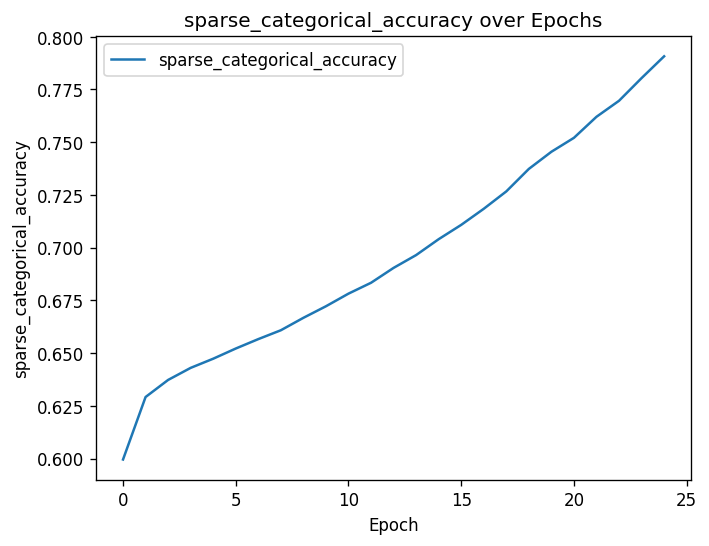

In [25]:
plot_model_metric('sparse_categorical_accuracy')

# Inference After Fine-tuning:

In [26]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></center></font>

<font color='green' size='4'><strong><font color='green' size='4'><strong>System: </strong></font></strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='red' size='4'><strong><font color='red' size='4'><strong>News: </strong></font></strong></font>
By . Daily Mail Reporter . Last updated at 12:12 PM on 29th September 2011 . Britain's major cities are among the hardest in Europe to get around without a car, according to research. London, Cardiff, Dublin, Edinburgh and Belfast were all in the bottom half of a 13-strong ease-of-travel city table released today. Stockholm was judged to be the best European city to get around without a car, followed by Helsinki, Prague, Paris and Berlin. Congested: London was in the bottom half of a list measuring ease of public transport use . But in the table compiled by the Campaign for Better Transport, London ranked eighth, Cardiff ninth, while Dublin, Edinburgh and Belfast were 10, 11, and 12 in the list respectively. Only Rome, in 13th and last place, was deemed to be less 'green' and public transport-friendly than the UK's main cities. The cities were judged on 16 categories, including ease of access to public transport, public attitudes to car use, congestion levels and the side effects from cars. Busy: Edinburgh was second only to London for congestion . London had the worst air quality and congestion of all the cities examined in the study. Londoners are also subjected to the highest fares. Public transport in Cardiff was cheaper than in the other UK capitals, but the city had the second lowest number of public transport trips per day and the lowest number of people commuting by public transport. Edinburgh was second only to London . for congestion and worse than Rome or Paris. Belfast finished bottom of . all the UK capitals despite having the longest cycling and public . transport networks. CBT . chief executive Stephen Joseph said: 'Car dependency damages . communities, affects our quality of life and has huge environmental . consequences, so the UK cities' poor standing should be of major concern . to politicians. A map showing the rankings of cities which are least dependent on cars in Europe . 'To . catch up with the best in Europe the UK Governments need to recognise . the economic benefits of good air quality and road safety, and ensure . public transport, walking and cycling are comparable to car use in terms . of cost, journey time and quality.'


<font color='cyan' size='4'><strong><font color='cyan' size='4'><strong>Summary: </strong></font></strong></font>


<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></center></font>

London is among hardest to get around without a car .
Cardiff, Dublin, Edinburgh and Belfast also fare badly .
Stockholm is rated the best for public transport .

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

Belfast was bottom of the CBT table, while Rome was top .

In [27]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></center></font>

<font color='green' size='4'><strong><font color='green' size='4'><strong>System: </strong></font></strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='red' size='4'><strong><font color='red' size='4'><strong>News: </strong></font></strong></font>
By . Lydia Warren . PUBLISHED: . 07:46 EST, 25 June 2013 . | . UPDATED: . 08:39 EST, 25 June 2013 . Killer: Marshall Lee Gore, 49, has been granted a last minute stay of execution in Miami . A murderer on Death Row in Florida has been granted a stay of execution just one hour before he was supposed to receive a lethal injection - after his lawyers claimed he is insane. Marshall Lee Gore, 49, a former escort service owner who strangled and stabbed exotic dancer Robyn Novick to death in 1988, was supposed to be put to death in Miami at 6pm on Monday. He has also been convicted of a second murder. But a federal appeals court temporarily halted the execution at the last minute and a court date has been set for Thursday for his lawyers to explore the possibility that he is insane. The stay came after Gore enjoyed his . 'last' meal of a rib-eye steak and a Coca-Cola. He did not touch his . side of a baked potato, the Miami Herald reported. The 11th Circuit Court of Appeals, which is based in Atlanta, said it would try to settle the matter before July 1, the newspaper added. Gore's attorneys have previously argued that he is mentally ill, and one lawyer claimed he was 'mentally deranged' and not responsible for his actions. During his trials, he had frequent verbal outbursts, laughed out loud and even howled. He has also contended that the date of his scheduled execution, June 24, 2013, adds up to 666 and that he is a target of 'Satan Worshippers who have threatened that date by mail for years'. But Gore has no significant history of mental illness and last month a panel of psychiatrists found that he was mentally sound. Death Row: He was supposed to die by lethal injection in the death chamber at Florida State Prison, pictured, but a court of appeals granted him a temporary stay as his lawyers said he is insane . They said that Gore claimed that the 'Illuminati' wanted him dead to sell his organs - a story they say he made up to manipulate the judicial process. 'This fantastic, imaginative scenario was patently a fabrication designed . to mislead the panel and avoid responsibility for his past actions,' the panel told the governor. Relatives of Novick, who had traveled from Ohio to witness the execution, were devastated, the Herald reported. The family of Susan Marie Roark, another of Gore's victims, was also present. 'They're upset,' said retired Lt. Neal Nydam, who was with the Roark family. 'This has been going on for 25 years. They're trying to find closure and it's not going to happen today.' Gore first kidnapped a stripper named Tina in March 1988, raped her, slit her throat and hit her across the head with a rock before leaving her to die in a rural area. But she survived and managed to alert police. Gore had also stolen her car - and her two-year-old son in the back seat. He was later found alive locked in a cabinet of an abandoned home in Georgia. While officers were searching for the boy, they found Novick's body. The 30-year-old had met Gore while working as a dancer in North Miami-Dade. Crimes: He killed two women in 1988 and raped another before kidnapping her two-year-old son . Gore was tracked down to Kentucky. When he was found, he had Tina's woman's bank and credit cards in his jacket pocket, according to court documents. Police also identified him as the person . who killed Roark. She had last been seen with Gore before vanishing in . April 1988. Her body was found off a rural forest road. Upon questioning about all three crimes and shown pictures of Novick's body, police said his eyes filled with tears and he said: 'If I did this, I deserve the death penalty.' Gore initially denied knowing any of the women, according to police. But he later testified that all three women worked for him at his escort service. In 1995, he was found guilty of Novick's murder and sent to Death Row. Gov. Scott signed the death warrant last month. His death would have been the state's third execution of the month.


<font color='cyan' size='4'><strong><font color='cyan' size='4'><strong>Summary: </strong></font></strong></font>


<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></center></font>

Former escort service owner Marshall Lee Gore, 49, killed two women in 1988 and kidnapped, raped and stabbed another .
He was to be put to death on Monday for the murders of one of his victims .
But an appeals court halted the execution at the last minute .
Court date scheduled for next week to settle whether or not he is insane .

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

<font color='green' size='4'><strong>System: </strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section. In the 'Summary' section, provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='red' size='4'><strong>News: </strong></font>
By . Lydia Warren . PUBLISHED: . 07:46 EST, 25 June 2013 . | . UPDATED: . 08:39 EST, 25 June 2013 . Killer: Marshall Lee Gore, 49, has been granted a last minute stay of execution in Miami . A murderer on Death Row in Florida has been granted a stay of execution just one hour before he was supposed to receive a lethal injection - after his lawyers claimed he is insane. Marshall Lee Gore, 49, a former escort service owner who strangled and stabbed exotic dancer Robyn Novick to death in 1988, was supposed to be put to death in Miami at 6pm on Monday. He has also been convicted of a second murder. But a federal appeals court temporarily halted the execution at the last minute and a court date has been set for Thursday for his lawyers to explore the possibility that he is insane. The stay came after Gore enjoyed his . 'last' meal of a rib-eye steak and a Coca-Cola. He did not touch his . side of a baked potato, the Miami Herald reported. The 11th Circuit Court of Appeals, which is based in Atlanta, said it would try to settle the matter before July 1, the newspaper added. Gore's attorneys have previously argued that he is mentally ill, and one lawyer claimed he was 'mentally deranged' and not responsible for his actions. During his trials, he had frequent verbal outbursts, laughed out loud and even howled. He has also contended that the date of his scheduled execution, June 24, 2013, adds up to 666 and that he is a target of 'Satan Worshippers who have threatened that date by mail for years'. But Gore has no significant history of mental illness and last month a panel of psychiatrists found that he was mentally sound. Death Row: He was supposed to die by lethal injection in the death chamber at Florida State Prison, pictured, but a court of appeals granted him a temporary stay as his lawyers said he is insane . They said that Gore claimed that the 'Illuminati' wanted him dead to sell his organs - a story they say he made up to manipulate the judicial process. 'This fantastic, imaginative scenario was patently a fabrication designed . to mislead the panel and avoid responsibility for his past actions,' the panel told the governor. Relatives of Novick, who had traveled from Ohio to witness the execution, were devastated, the Herald reported. The family of Susan Marie Roark, another of Gore's victims, was also present. 'They're upset,' said retired Lt. Neal Nydam, who was with the Roark family. 'This has been going on for 25 years. They're trying to find closure and it's not going to happen today.' Gore first kidnapped a stripper named Tina in March 1988, raped her, slit her throat and hit her across the head with a rock before leaving her to die in a rural area. But she survived and managed to alert police. Gore had also stolen her car - and her two-year-old son in the back seat. He was later found alive locked in a cabinet of an abandoned home in Georgia. While officers were searching for the boy, they found Novick's body. The 30-year-old had met Gore while working as a dancer in North Miami-Dade. Crimes: He killed two women in 1988 and raped another before kidnapping her two-year-old son . Gore was tracked down to Kentucky. When he was found, he had Tina's woman's bank and credit cards in his jacket pocket, according to court documents. Police also identified him as the person . who killed Roark. She had last been seen with Gore before vanishing in . April 1988. Her body was found off a rural forest road. Upon questioning about all three crimes and shown pictures of Novick's body, police said his eyes filled with tears and he said: 'If I did this, I deserve the death penalty.' Gore initially denied knowing any of the women, according to police. But he later testified that all three women worked for him at his escort service. In 1995, he was found guilty of Novick's murder and sent to Death Row. Gov.Ethics group claims Florida has not offered him a fair trial .
Gore's lawyers claim he is insane and that he is a target of Satan worshippers .
Court of appeals temporarily halted execution after hearing arguments .
He will be put to death on June 24, 2013 .
Relatives of the other two women who were killed by the killer are also present .